# C14-hepatocyte analysis

In [11]:
# m = c14.models.liver.A()

# path = c14.models.liver.default_path

# from scipy.interpolate import UnivariateSpline

# ploidy_data = pd.read_excel(path)
# ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
#                       mean(axis='columns'))
# ploidy_data /= 100.0
# ploidy_data['age'] *= 100

# ploidy = UnivariateSpline(ploidy_data['age'].values,
#                                ploidy_data['2C_mean'].values,
#                                ext=3, k=2)

# t = np.linspace(0, 100)
# plt.plot(t, m.ploidy(t))
# plt.plot(t, ploidy(t))

default_parameters -> fit

default_limit -> physical

parameters -> physical

In [12]:
import datetime
from IPython.display import display
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

mem = joblib.Memory(location='/scratch/tmp/fabrost/hepato', verbose=0)

import logging

%load_ext rpy2.ipython

# logging.basicConfig(filename='c14.log',
#                              filemode='a',
#                              format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
#                             datefmt='%H:%M:%S',
#                              level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [13]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

In [14]:
# %load_ext autoreload
# %autoreload 2
import c14
import c14.models.liver
import c14.models.minimal

## Data

In [15]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [16]:
edata_young = c14.exp_data(data.query('age <= 50'))
edata_old = c14.exp_data(data.query('age > 50'))

## Fit the models

In [17]:
@mem.cache
def fit_model(edata, model, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    print(f'Fitting model {model.__name__}')
    result = {'model': model()}
    result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
    result['vis'] = c14.visualisze(model=result['model'],data=edata,step_size=step_size)
    result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
    try:
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
    except:
        print(f'Multistart found no valid results for model {model.__name__}')
    try:
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'], ignore_physics=True)
    except:
        print(f'Could not calculate errors for {model.__name__}')
    return result

In [18]:
def fit_models(edata, models, step_size=0.1, optimize_minuit_multistart_kwargs=dict(n=100,processes=8)):
    results = {model.__name__: fit_model(edata, model, step_size, optimize_minuit_multistart_kwargs)
               for model in models}
    return results

In [19]:
models = c14.models.liver.models_list + [c14.models.minimal.POP1]
models

[c14.models.liver.D,
 c14.models.liver.R,
 c14.models.liver.K,
 c14.models.liver.R2K24,
 c14.models.minimal.POP1]

In [20]:
init_limit = {'r2': (-3, 0), 
              'r2_0': (-3, 0), 
              'r2_100': (-3, 0), 
              'r4': (-3, 0),
              'lambda2': (-3, 0),
              'lambda4': (-3, 0),
              'kappa24': (-3, 0),
              'kappa24_0': (-3, 0),
              'kappa24_100': (-3, 0),
              'kappa42': (-3, 0),
              'delta2': (-3, 0),
              'delta2_0': (-3, 0),
              'delta2_100': (-3, 0),
              'delta4': (-3, 0),
              'f': (1, 3),
              'lambda_': (-3, 0),
              'r2_0': (-3, 0),
              'r2_1': (-3, 0),
              'r2_100': (-3, 0),
              't_step': (np.log10(5), np.log10(70))
             }

In [21]:
# %%time
# results = fit_models(edata, models, step_size=2, 
#                      optimize_minuit_multistart_kwargs=dict(n=10, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [22]:
# models = [c14.models.liver.R2K24]

In [23]:
# fit_model.clear()

In [24]:
%%time
results = fit_models(edata, models, step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=100, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 665 ms, sys: 0 ns, total: 665 ms
Wall time: 663 ms


In [25]:
# %%time
# results = fit_models(edata, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [26]:
%%time
results_K_1000 = fit_models(edata, [c14.models.liver.K], step_size=0.5, 
                     optimize_minuit_multistart_kwargs=dict(n=1000, 
                                                            processes=7, 
                                                            init_limit=init_limit)
                    )

CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.19 s


In [27]:
results.update(results_K_1000)

In [28]:
# %%time
# results_young = fit_models(edata_young, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [29]:
# %%time
# results_old = fit_models(edata_old, models, step_size=0.5, 
#                      optimize_minuit_multistart_kwargs=dict(n=100, 
#                                                             processes=7, 
#                                                             init_limit=init_limit)
#                     )

In [30]:
def summarise(results):
    parameters = pd.concat(
        [result['vis'].get_parameter(result['point_estimate'], 
                                     result['cov'], 
                                     t_eval=[0, 80])
         .assign(model = name).reset_index() for name, result in results.items()
        ], ignore_index=True)

    parameters['point_estimate'] = parameters['point_estimate'].astype(float)
    parameters['lower'] = parameters['lower'].astype(float)
    parameters['upper'] = parameters['upper'].astype(float).replace(np.inf, 1e99)
    parameters['parameter'] = parameters['parameter'].astype(str)
    parameters['time'] = parameters['time'].astype(str)

    parameters['ymin'] = parameters['point_estimate'] - parameters['lower']
    parameters['ymax'] = parameters['upper'] - parameters['point_estimate']
    return parameters

In [31]:
parameters = summarise(results)
# parameters_young = summarise(results_young)
# parameters_old = summarise(results_old)

## Parameter Values

### Detailed

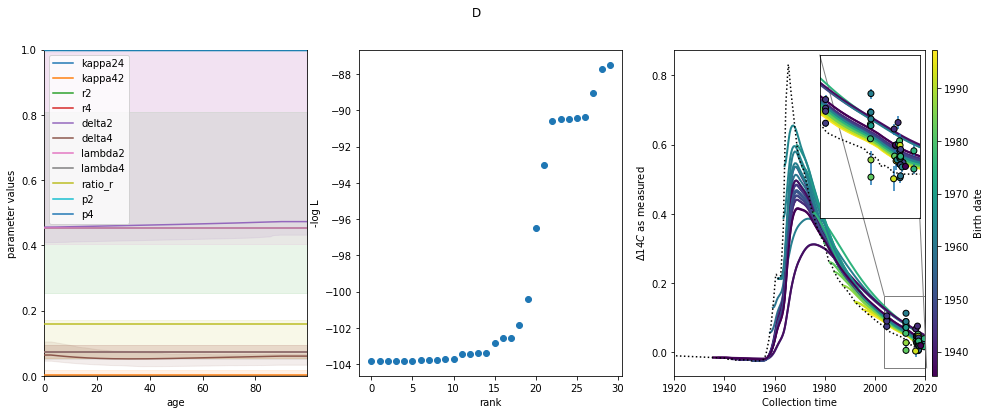

point_estimate        lower       upper
time parameter                                          
0    delta2            0.455732     0.410314     1.05627
     delta4           0.0636877     0.051158    0.102496
     kappa24        0.000100842  9.58529e-06  0.00106091
     kappa42         0.00164378  0.000163198   0.0165567
     lambda2           0.454189     0.406763     1.06475
     lambda4           0.073695     0.050903   0.0866211
     p2                0.999778      0.99621    0.999703
     p4                0.999778      0.99621    0.999703
     r2                0.454088     0.254846    0.809101
     r4               0.0720512    0.0542265    0.095735
     ratio_kappa        16.3006     0.256754     29.2382
     ratio_r           0.158672    0.0536223    0.175562
50   delta2            0.463972     0.419329     1.06425
     delta4           0.0534592     0.033915   0.0702547
     kappa24        0.000100842  9.58529e-06  0.00106091
     kappa42         0.00164378  0.000163198   0.0165567
     lambda2           0.454189     0.406763     1.06475
     lambda4           0.073695     0.050903   0.0864457
     p2                0.999778     0.996189    0.999703
     p4                0.999778     0.996189    0.999703
     r2                0.454088     0.254846    0.809101
     r4               0.0720512    0.0542265    0.095735
     ratio_kappa        16.3006     0.256754     28.8195
     ratio_r           0.158672    0.0535358    0.175589
80   delta2            0.470277     0.427293     1.07002
     delta4           0.0588288    0.0377335   0.0664159
     kappa24        0.000100842  9.58529e-06  0.00106091
     kappa42         0.00164378  0.000163198   0.0165567
     lambda2           0.454189     0.406763     1.06195
     lambda4           0.073695     0.050903   0.0862665
     p2                0.999778      0.99627    0.999703
     p4                0.999778      0.99627    0.999703
     r2                0.454088     0.254846    0.809101
     r4               0.0720512    0.0542265    0.095735
     ratio_kappa        16.3006     0.252342     28.6919
     ratio_r           0.158672    0.0537931    0.175173

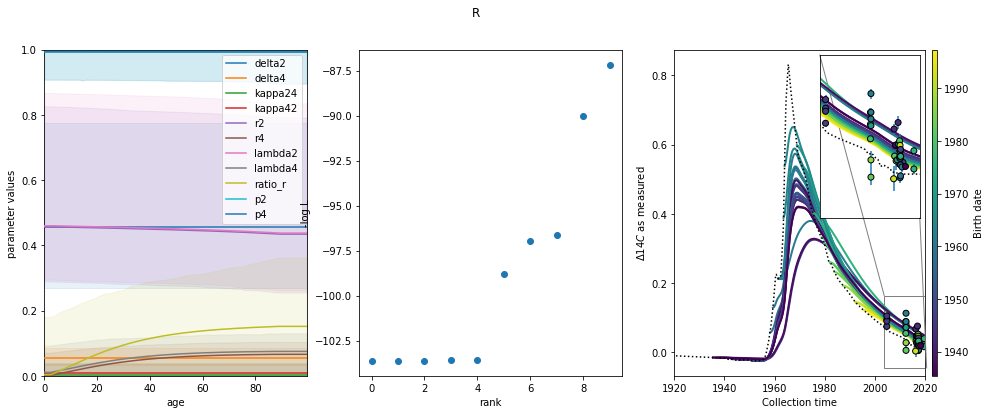

point_estimate        lower      upper
time parameter                                         
0    delta2            0.456277     0.268293   0.775976
     delta4           0.0539877     0.034562  0.0843318
     kappa24         0.00313471  0.000255643  0.0384381
     kappa42         0.00900677   0.00226437  0.0358254
     lambda2           0.460146     0.276161   0.765531
     lambda4          0.0105085    0.0325991   0.106793
     p2                0.993188     0.979868   0.999221
     p4                0.993188     0.979868   0.999221
     r2                0.457012     0.271792   0.757969
     r4              0.00150172    0.0215812   0.084396
     ratio_kappa        2.87324     0.608434    38.2109
     ratio_r         0.00328595    0.0347698   0.265961
50   delta2            0.456277     0.268293   0.775976
     delta4           0.0539877     0.034562  0.0843318
     kappa24         0.00313471  0.000255643  0.0384381
     kappa42         0.00900677   0.00226437  0.0358254
     lambda2           0.450577     0.258869   0.731865
     lambda4          0.0664429    0.0649679   0.137154
     p2                0.993043     0.985884   0.999301
     p4                0.993043     0.985884   0.999301
     r2                0.447442     0.252634   0.730212
     r4               0.0574361    0.0564937   0.110314
     ratio_kappa        2.87324     0.831039    43.6283
     ratio_r           0.128365      0.08469   0.394321
80   delta2            0.456277     0.268293   0.775976
     delta4           0.0539877     0.034562  0.0843318
     kappa24         0.00313471  0.000255643  0.0384381
     kappa42         0.00900677   0.00226437  0.0358254
     lambda2            0.44154     0.241513   0.719861
     lambda4          0.0741075    0.0727779   0.149752
     p2                  0.9929      0.99325   0.999478
     p4                  0.9929      0.99325   0.999478
     r2                0.438405     0.239813   0.716836
     r4               0.0651007    0.0647514    0.11477
     ratio_kappa        2.87324      2.00441    63.2096
     ratio_r           0.148494    0.0970842   0.444725

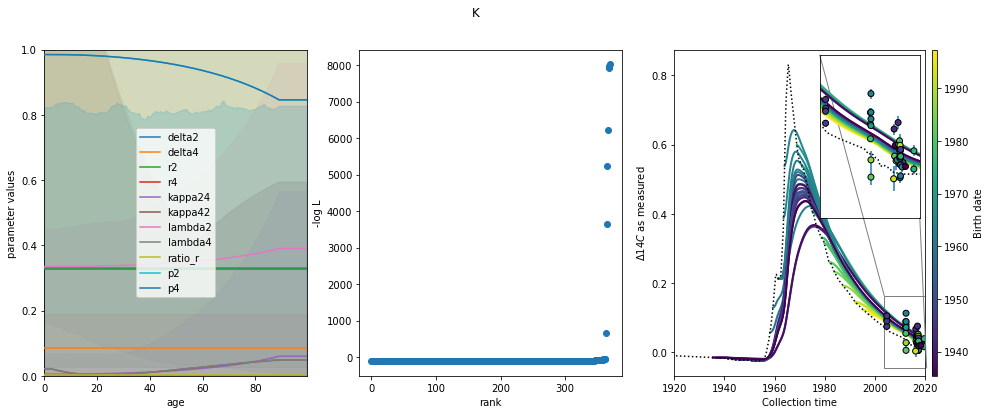

point_estimate        lower       upper
time parameter                                          
0    delta2            0.328602    0.0281945     3.82979
     delta4           0.0837022  3.43283e-16  2.0409e+13
     kappa24         0.00504622    0.0211342    0.238944
     kappa42          0.0213481     0.381679     1.62373
     lambda2           0.335196    0.0380402    0.715077
     lambda4           0.021928     0.462379     1.62794
     p2                0.984945     0.226636    0.779894
     p4                0.984945     0.226636    0.779894
     r2                 0.33015   0.00493595     22.0827
     r4             0.000579863  1.77094e-06    0.189866
     ratio_kappa        4.23051      10.8058     24.0756
     ratio_r         0.00175636  0.000474996     3.69694
50   delta2            0.328602    0.0281945     3.82979
     delta4           0.0837022  3.43283e-16  2.0409e+13
     kappa24          0.0160903    0.0202037     1.12476
     kappa42          0.0185468     0.156886     3.68605
     lambda2           0.346241    0.0407523     1.72831
     lambda4          0.0191267     0.181877     3.68627
     p2                0.953528     0.239363    0.788243
     p4                0.953528     0.239363    0.788243
     r2                 0.33015   0.00493595     22.0827
     r4             0.000579863  1.77094e-06    0.189866
     ratio_kappa        1.15267      3.60768     7.80492
     ratio_r         0.00175636  0.000316229     1.40267
80   delta2            0.328602    0.0281945     3.82979
     delta4           0.0837022  3.43283e-16  2.0409e+13
     kappa24          0.0440789    0.0194731     5.77046
     kappa42          0.0426077    0.0557679     8.79892
     lambda2           0.374229    0.0406267     6.31397
     lambda4          0.0431875    0.0717075     8.79899
     p2                0.882214    0.0860817    0.827177
     p4                0.882214    0.0860817    0.827177
     r2                 0.33015   0.00493595     22.0827
     r4             0.000579863  1.77094e-06    0.189866
     ratio_kappa       0.966623      1.55252     3.28809
     ratio_r         0.00175636  0.000414153    0.707407

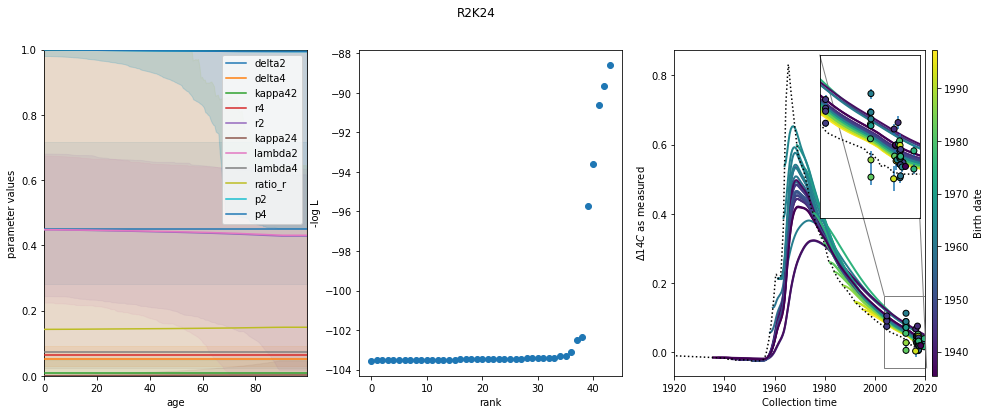

point_estimate       lower       upper
time parameter                                         
0    delta2            0.450021    0.282019    0.718103
     delta4            0.051467   0.0290712    0.091116
     kappa24        0.000205381  0.00134908  0.00637793
     kappa42          0.0079398  0.00133148   0.0473462
     lambda2           0.448126    0.284204    0.706202
     lambda4          0.0717159    0.016848    0.127376
     p2                0.999542    0.980991    0.997511
     p4                0.999542    0.980991    0.997511
     r2                0.447921    0.281529    0.701868
     r4               0.0637761  0.00380369     1.06933
     ratio_kappa        38.6589     1.00994     20.6301
     ratio_r           0.142383  0.00270549    0.127645
50   delta2            0.450021    0.282019    0.718103
     delta4            0.051467   0.0290712    0.091116
     kappa24         0.00179647    0.005505   0.0205901
     kappa42          0.0079398  0.00133148   0.0473462
     lambda2           0.441931    0.285806    0.704033
     lambda4          0.0717159   0.0166555    0.127426
     p2                0.995935    0.940102    0.990225
     p4                0.995935    0.940102    0.990225
     r2                0.440135    0.272464    0.683299
     r4               0.0637761  0.00380369     1.06933
     ratio_kappa        4.41967    0.284679     6.16287
     ratio_r           0.144901   0.0027772    0.129014
80   delta2            0.450021    0.282019    0.718103
     delta4            0.051467   0.0290712    0.091116
     kappa24         0.00240988   0.0117582   0.0471133
     kappa42          0.0079398  0.00133148   0.0473462
     lambda2           0.434517    0.309588    0.703977
     lambda4          0.0717159   0.0164411    0.125488
     p2                0.994454    0.871002    0.979543
     p4                0.994454    0.871002    0.979543
     r2                0.432107    0.270863     0.67352
     r4               0.0637761  0.00380369     1.06933
     ratio_kappa        3.29469     0.12868     2.73557
     ratio_r           0.147593  0.00275295    0.122272

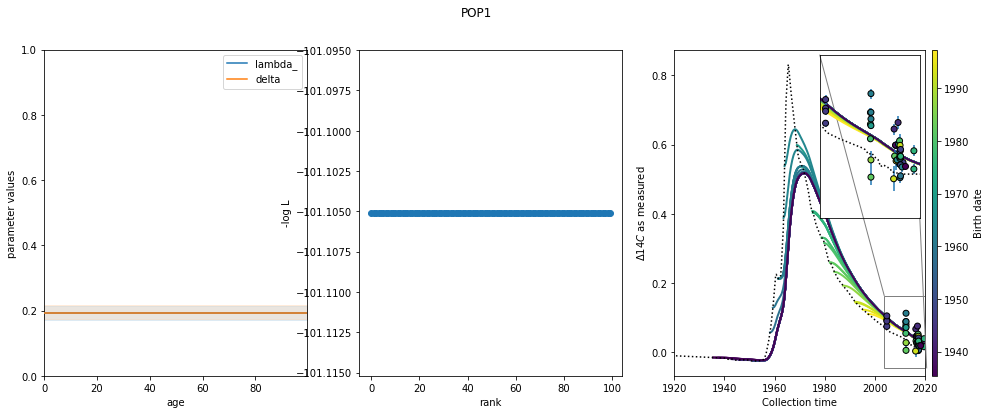

point_estimate     lower     upper
time parameter                                   
0    delta           0.192405    0.1709  0.214937
     lambda_         0.192405  0.172035  0.215187
50   delta           0.192405    0.1709  0.214937
     lambda_         0.192405  0.172035  0.215187
80   delta           0.192405    0.1709  0.214937
     lambda_         0.192405  0.172035  0.215187

In [32]:
for name, result in results.items():
    if name not in ['']:
        no_plot = ['ratio_kappa']
        fig, axs = plt.subplots(1, 3, figsize=(16,6))
        fig.suptitle(name)
        result['vis'].plot_parameter(result['point_estimate'], result['errors'],
                                         no_plot=no_plot, axis=axs[0])
#         result['vis'].plot_parameter(result['point_estimate'], 
#                                          no_plot=no_plot, axis=axs[0])

        axs[0].legend()
        axs[0].set_ylabel('parameter values')
        axs[0].set_ylim(0, 1)

        fval = result['multistart_result']['fval']
        axs[1].scatter(np.arange(len(fval)), fval.values)
        axs[1].set_xlabel('rank')
        axs[1].set_ylabel('-log L')
    #         axs[1].set_xlim(0, 100)
        
        _ = result['vis'].odeint()
        result['vis'].plot_simdata( axis=axs[2], cmap=plt.cm.viridis)
        axs[2].set_xlim(1920, 2020)

        plt.show()

        try:
            display(result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=[0, 50, 80]
                                               ))
        except:
            pass

### Summarized

In [33]:
parameters.query('model == "D"')

,time,parameter,point_estimate,lower,upper,model,ymin,ymax
0,0,delta2,0.455732,0.410911,0.983672,D,0.044822,0.527939
1,0,delta4,0.063688,0.049997,0.100880,D,0.013691,0.037192
2,0,kappa24,0.000101,0.000010,0.001061,D,0.000091,0.000960
3,0,kappa42,0.001644,0.000163,0.016557,D,0.001481,0.014913
4,0,lambda2,0.454189,0.410246,0.984852,D,0.043943,0.530663
5,0,lambda4,0.073695,0.053093,0.089117,D,0.020602,0.015422
6,0,p2,0.999778,0.996496,0.999698,D,0.003282,-0.000080
7,0,p4,0.999778,0.996496,0.999698,D,0.003282,-0.000080
8,0,r2,0.454088,0.254846,0.809101,D,0.199242,0.355012
9,0,r4,0.072051,0.054227,0.095735,D,0.017825,0.023684


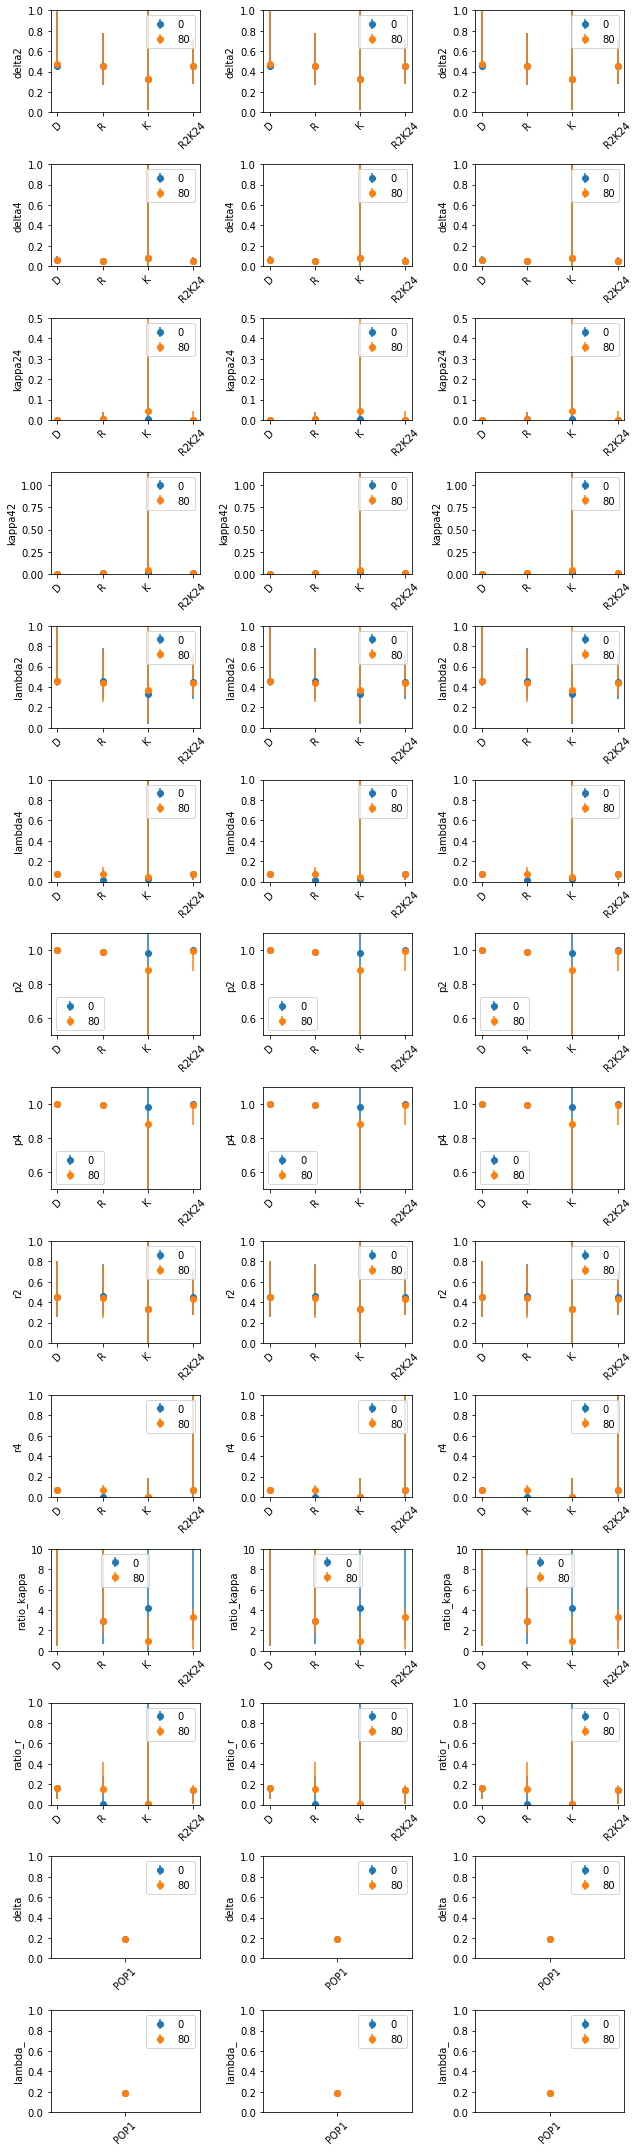

In [34]:
p_names = parameters['parameter'].unique()
# paras = [parameters, parameters_young, parameters_old]
paras = 3*[parameters]
fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



ylimits = {'delta2': (0, 1),
           'p2': (0.5, 1.1),
           'p4': (0.5, 1.1),
           'kappa24': (0, 0.5),
           'kappa42': (0, 1.15),
          'ratio_kappa': (0, 10)}

for parameter, axs in zip(p_names, axss):
    for para, ax in zip(paras, axs):
        data = para[para['parameter'] == parameter]
        for time, time_data in data.groupby('time'):
            ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
                        data=time_data, marker='o', ls='None', label=time)
            ax.legend()
            ax.set_ylabel(parameter)
        try:
            ax.set_ylim(ylimits[parameter])
        except:
            ax.set_ylim(0, 1)
        ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

## Export

In [109]:
# model = 'A'

# time = np.linspace(0, 100, 101)
# df = pd.DataFrame(results[model]['model'].get_implicit_parameters(time))[['r2', 'kappa24', 'ratio_r', 'p']]
# # df.columns=['r2', 'r4', 'kappa24', 'kappa42', 'ratio_r']
# df['r4'] = results[model]['model'].r4
# df['kappa42'] = results[model]['model'].kappa42
# df['delta2'] = results[model]['model'].delta2
# df['delta4'] = results[model]['model'].delta4
# df['age'] = time
# df['ploidy'] = c14.models.liver.A().ploidy(df['age'])
# df.head()

# result = results[model]
# df = result['vis'].get_parameter(result['point_estimate'], result['cov'], t_eval=time).unstack().reset_index()

# df = df[['time', 'point_estimate']]

# df.to_excel('../../../results/parameters_A.xlsx')

## Model selection

In [33]:
# results_backup = results.copy()

In [40]:
results = results_backup.copy()

In [41]:
_ = results.pop('POP1', None)

In [42]:
model_selection_results = pd.DataFrame(
    pd.Series(
        {name: result['op'].calc_aicc(result['point_estimate'])
         for name, result in results.items()}, name='cAIC'))
model_selection_results['loglike'] = [result['op'].loglike_dict(result['point_estimate']) for name, result in results.items()]
model_selection_results['nparas'] = [result['model'].nparas for name, result in results.items()] 
model_selection_results['nparas'] += 1
model_selection_results = pd.DataFrame(model_selection_results)
model_selection_results['delta'] = model_selection_results['cAIC'] - model_selection_results['cAIC'].min() 
model_selection_results['w'] = np.exp(-0.5*model_selection_results['delta']) / np.exp(-0.5*model_selection_results['delta']).sum()
model_selection_results['ER'] = model_selection_results['w'].max() / model_selection_results['w']
model_selection_results.sort_values('cAIC')

,cAIC,loglike,nparas,delta,w,ER
D,-195.901332,103.807809,5,0.000000,0.300460,1.000000
R,-195.530892,103.622589,5,0.370440,0.249658,1.203483
R2K24,-195.394908,103.554597,5,0.506424,0.233248,1.288156
K,-195.247127,103.480706,5,0.654206,0.216634,1.386944


In [111]:
# parameters = parameters.merge(model_selection_results, left_on='model', right_index=True)

In [ ]:
# parameters['log10_point_estimate'] = np.log10(parameters['point_estimate'])
# parameters['log10_lower'] = np.log10(parameters['lower'])
# parameters['log10_upper'] = np.log10(parameters['upper'])
# parameters.head()

# parameters['log10_error_lower'] = parameters['log10_point_estimate'] - parameters['log10_lower']
# parameters['log10_error_upper'] = -parameters['log10_point_estimate'] + parameters['log10_upper']

# parameters['log10_error'] = parameters[['log10_error_lower', 'log10_error_upper']].mean(axis='columns')

# parameters.head()

# def parameter_average(data):
#     parameter = data['parameter'].iloc[0]
#     log10_mean = np.average(data['log10_point_estimate'], weights=data['w'])
#     log10_error = np.average(
#         np.sqrt(data['log10_error']**2 + (data['log10_point_estimate'] - log10_mean)**2),
#         weights=data['w'])
#     point_estimate = 10**log10_mean
#     lower = 10**(log10_mean-log10_error)
#     upper = 10**(log10_mean+log10_error)
#     return pd.Series({
#         'point_estimate': point_estimate,
#         'lower': lower,
#         'upper': upper,
#         'model': 'average',
#         'ymin': point_estimate - lower,
#         'ymax': point_estimate + upper,
#         'log10_point_estimate': log10_mean,
#         'log10_error': log10_error
#     })

# rates = ["r2", "r4", "delta2", "delta4", "kappa24", "kappa42", "lambda2", "lambda4"]

# averaged_parameters = (parameters
#                        .query('parameter in @rates')
#                        .groupby(['time', 'parameter'])
#                        .apply(parameter_average)
#                        .reset_index()
#                         )

In [119]:
# parameters = pd.concat([parameters, averaged_parameters], axis='rows', sort=False)

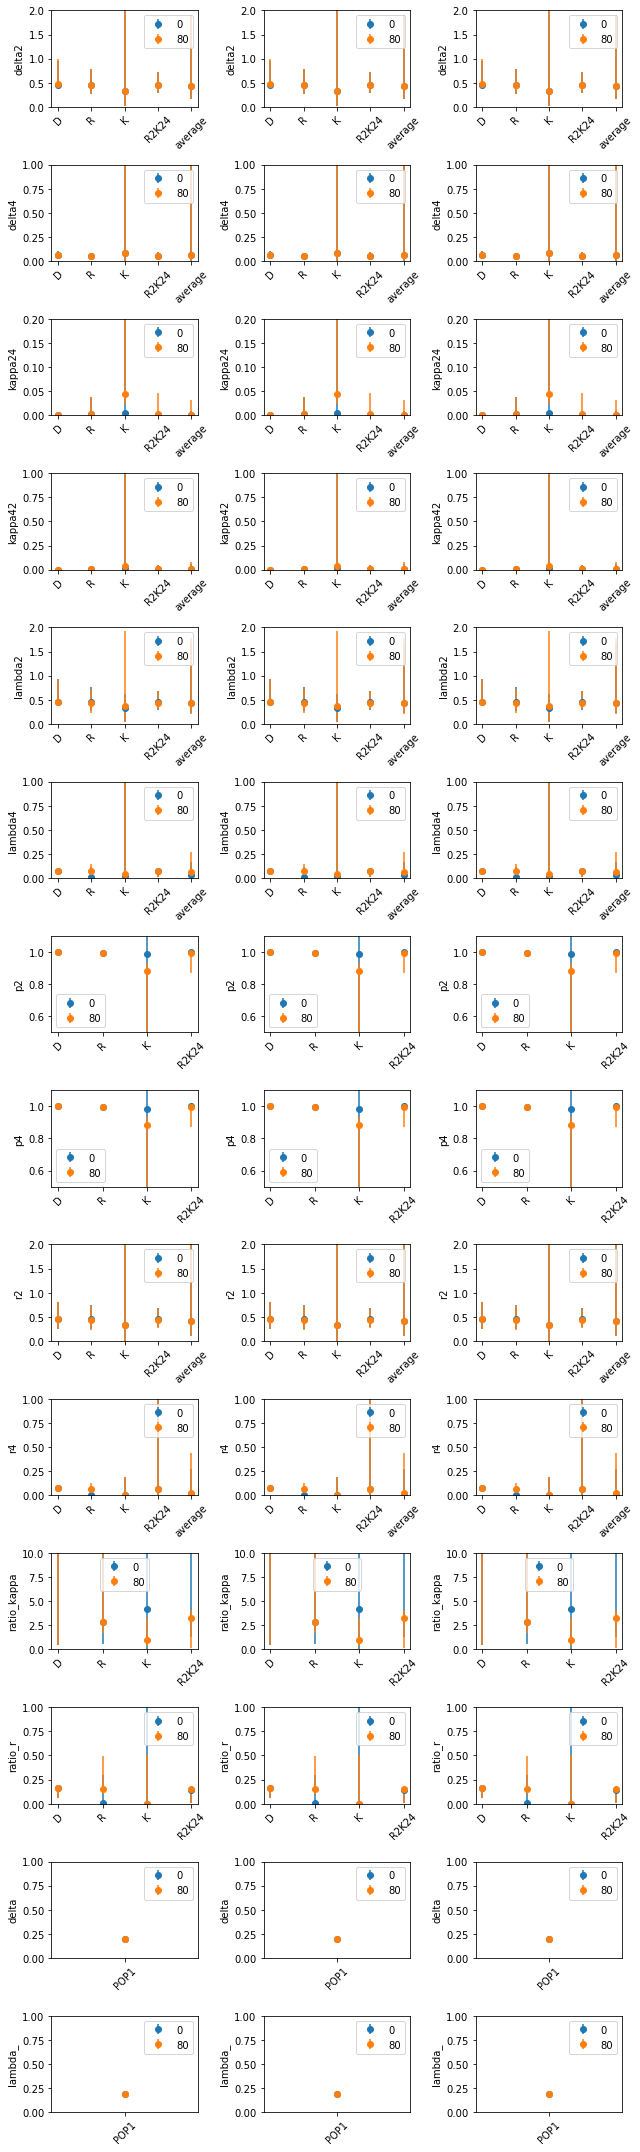

In [120]:
# p_names = parameters['parameter'].unique()
# paras = 3*[parameters]
# fig, axss = plt.subplots(len(p_names), len(paras), figsize=(9, 30))



# ylimits = {'delta2': (0, 2),
#            'delta4': (0, 1),
#            'lambda2': (0, 2),
#            'r2': (0, 2),
#            'p2': (0.5, 1.1),
#            'p4': (0.5, 1.1),
#            'kappa24': (0, 0.2),
#           'ratio_kappa': (0, 10)}

# for parameter, axs in zip(p_names, axss):
#     for para, ax in zip(paras, axs):
#         data = para[para['parameter'] == parameter]
#         for time, time_data in data.groupby('time'):
#             ax.errorbar('model', 'point_estimate', time_data[['ymin', 'ymax']].T.abs().values,
#                         data=time_data, marker='o', ls='None', label=time)
#             ax.legend()
#             ax.set_ylabel(parameter)
#         try:
#             ax.set_ylim(ylimits[parameter])
#         except:
#             ax.set_ylim(0, 1)
#         ax.tick_params(axis='x', labelrotation=45)

# plt.tight_layout()
# plt.show()